In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "truncnorm", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel","viridis")
install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('/home/r27user6/RMST_Code/Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.495229 
Variance of RMST estimation of Control arm is: 2.732952e-05 
RMST of Experiment arm is: 0.6448322 
Variance of RMST estimation of Experiment arm is: 2.831875e-05

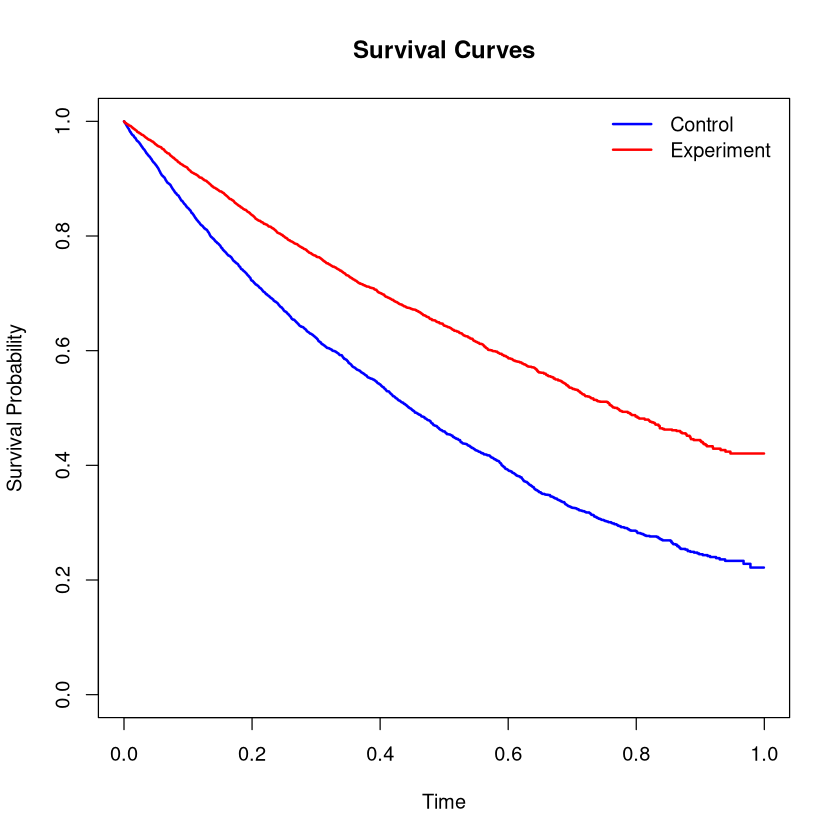

In [36]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.507374 
Variance of RMST estimation of Control arm is: 1.233716e-05 
RMST of Experiment arm is: 0.6629768 
Variance of RMST estimation of Experiment arm is: 1.260073e-05

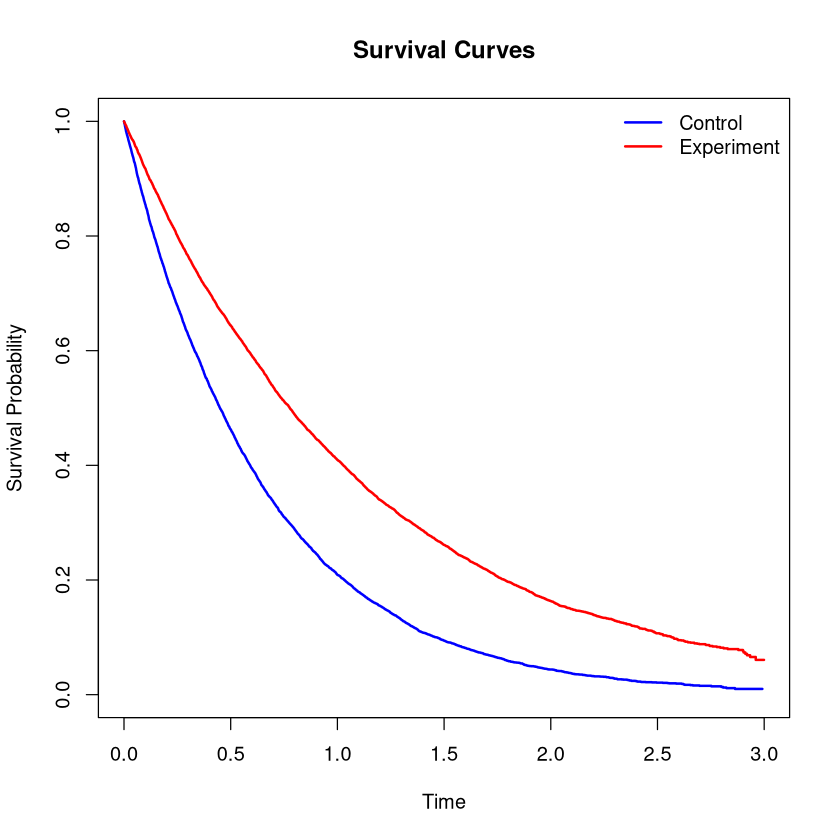

In [19]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$


In [ ]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 
### <span style="color:yellow"> I am trying to reproduce the result in Jung(2017) by grid searching 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year  
### <span style="color:yellow">The power is almost the same as 2 stages log rank design


In [ ]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.0999

[1] 0.9098

# Our Rejection Region
### <span style="color:yellow">E and C are the RMST value of experiment group and control group respectively
### subscript 1 means interim period, 2 for final period
#### Stage I : process to stage II (reject $H_0$) when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$, where $m_1>0$
### Stage II:
#### reject $H_0$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2},\ $  $m_1, m_2 >0$


### By the asymptotic normality of RMST:
$$
 \textcolor{lightgreen}{[E1-C1,\ E1,\ E2-C2,\ E2] \sim \mathcal{N}\ (\ \hat{\mu},\ \hat{\Sigma}\ )}
$$

$$
\hat{\Sigma} = 
 \left[
 \begin{matrix}
   Var(E1)+Var(C1) & Var(E1) & Cov(E1,E2)+Cov(C1,C2) & Cov(E1,E2) \\
                   & Var(E1) & Cov(E1,E2) & Cov(E1,E2) \\
                   &         & Var(E2)+Var(C2) & Var(E2)\\
                   &         &                 & Var(E2)\\
  \end{matrix}
\right]
$$

## Monte Carlo
$ var[\widehat{RMST_{E1}}]=\frac{1}{B}\sum\limits_{i = 1}^{B} (\widehat{RMST_{E1,i}} - \bar{RMST_{E1}})^2$

Similar to Lu(2021) 

$$
 \left[
 \begin{matrix}
   Var(\hat{E1}) & Cov(\hat{E1}, \hat{E2}) \\
   Cov(\hat{E1}, \hat{E2}) & Var{\hat{E2}} \\
  \end{matrix}
  \right] = 

\frac{1}{B}\sum\limits_{i = 1}^{B} 
 \left[
 \begin{matrix}
   \widehat{RMST_{E1}} - \bar{RMST_{E1}} \\
   \widehat{RMST_{E2}} - \bar{RMST_{E2}} \\
  \end{matrix}
  \right] ^{\bigotimes2}_i 
$$

$ \bar{RMST_{E1}} = \frac{1}{B}\sum^{B}_{i = 1}RMST_{E1,i}$ is the mean RMST value of simulation
#### <span style="color:yellow">Use the setting of Jung 2017 table 1 first row (Minimax)




In [84]:
set.seed(2024)
sim_size <- 10000 
N <- 120
r <- 60
acc_time <- N / r
cen_time <- 1
lambda_H1 <- 0.9
HR <- 1.7
lambda_H0 <- 0.9 * 1.7
change_time <- 1
interim <- 0.6 * acc_time
n <- ceiling(N / 2)
alpha <- 0.05
tau_f <- 2.5

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
                                
rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = tau_f, sim_size = sim_size)                                 
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = tau_f, sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

# log-rank data
lr_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h0_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
# Get W/sigma
z_stats_h1_int <- lr_h1_int$z_stats
z_stats_h1_fin <- lr_h1_fin$z_stats
z_stats_h0_int <- lr_h0_int$z_stats
z_stats_h0_fin <- lr_h0_fin$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin) 
# corr(W1, W | H0)
corr_h0 <- sqrt(mean(lr_h0_int$var_w) / mean(lr_h0_fin$var_w))         


______________
# <span style="color:yellow">  Parameter Optimization (Grid Search)
Reference: Zhou(2017) BOP2 Bayesian design. DOI:10.1002/sim.7338

#### In order to solve the critical values ($m_1,\ q_1,\ m_2,\ q_2$), a function that can control the normal probability is required. The following $\mathcal{f}(n)$  is what we proposed.
$$
\large \mathcal{f}(n) = \mathcal{e}^{-\ \gamma · \frac{n}{N}},\ \gamma>0
$$
#### $ \mathcal{f}(n)$ is a monotonously decereasing funciton of n, which means that two probability constraints in interim period will go up when the interim sample size n decrease. <span style="color:yellow"> It leads to a small early stop probability with an insufficient interim sample size. $n$ is the sample size(2 arms) of interim period. $N$ is the final total sample size of 2 arms. 
$$
D_i = E_i - C_i
$$
#### Then we set the following constraints:
$$
\begin{aligned}
\large P(E_1 > q_1\ |\ D_1 > m_1) &=  \mathcal{f}(n) \\
\large P(E_2 > q_2\ |\ D_2 > m_2) &=  \mathcal{f}(N) \\
\end{aligned}
$$

### Search (m,q) stage by stage. Given a threshold prob under H1
$$
\large P (E_i > q_i\ |\ D_i > m_i | H_1) = p_i
$$
### Make use of the normality of conditional distribution, $\rho$ is the correlation.
$$
E_1 | D_1\ \sim N(\mu, \sigma) \\
\\
\mu = (\mu_{E1} + \rho \cdot \sigma_{E1}/\sigma_{D1} \cdot (D_1 - \mu_{D1}))\\
\\
\Sigma = \sigma_{E1}^2 \cdot (1 - \rho^2)\\
$$

#### Then we grid search $(\lambda, \gamma)$ . Each pair of $(\lambda, \gamma)$ determines a set of ($m_1,\ q_1,\ m_2,\ q_2$) by normal calculation. Record critical values sets that yield the desirable overall type I error $\alpha$:
$$
\large P(D_1>m_1\ \&\  E_1>q_1\ \&\  D_2>m_2\ \&\  E_2>q_2\ |H_0) < \alpha
$$
#### Find the most powerful one under $H_1$ among these ($m_1,\ q_1,\ m_2,\ q_2$)

#### <span style="color:yellow"> Remark: for single stage design, we only search under the last two constraints.
#### * The grid searching procedure above is packed in function: 'adp_grid_src'

In [85]:
set.seed(2024)
best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = 0.05, power = 0.8, sim_size = sim_size, method = 'Complex')

best_rmst <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = 0.05, power = 0.8, sim_size = sim_size, method = 'Simple')

best_lr <- find_m_logrank(logrank_data = logrank_data, search_times = 200, corr_h0 = corr_h0,
                int_n = interim * r, fin_n = 2 * n, alpha = 0.05, power = 0.8, sim_size = sim_size)

best_lr <- best_lr[which(best_lr$EN0 == min(best_lr$EN0, na.rm = TRUE)), ]
best_rmst <- best_rmst[which(best_rmst$EN0 == min(best_rmst$EN0, na.rm = TRUE)), ]   
best_our1 <- best_our[which(best_our$power == min(best_our$power, na.rm = TRUE)), ]  

,m1,m2,q1,q2,gamma,lambda,PET0,PET1,alpha,power,PET,EN0,EN1,EN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,-0.08324613,-0.048408717,0.4818469,0.7646392,0.026,0.01,0.3929,0.0177,0.0492,0.9650,0.20530,101.1408,119.1504,110.1456
411,-0.08324613,-0.048408717,0.4813035,0.7646392,0.026,0.02,0.3908,0.0176,0.0492,0.9651,0.20420,101.2416,119.1552,110.1984
33,-0.08324613,-0.048408717,0.4807479,0.7646392,0.026,0.03,0.3886,0.0175,0.0492,0.9651,0.20305,101.3472,119.1600,110.2536
331,-0.08324613,-0.048408717,0.4801611,0.7646392,0.026,0.04,0.3860,0.0174,0.0492,0.9652,0.20170,101.4720,119.1648,110.3184
332,-0.08324613,-0.048408717,0.4796192,0.7646392,0.026,0.05,0.3845,0.0172,0.0493,0.9654,0.20085,101.5440,119.1744,110.3592
333,-0.08324613,-0.048408717,0.4790478,0.7646392,0.026,0.06,0.3827,0.0169,0.0493,0.9657,0.19980,101.6304,119.1888,110.4096
334,-0.08324613,-0.048408717,0.4784037,0.7646392,0.026,0.07,0.3807,0.0169,0.0493,0.9657,0.19880,101.7264,119.1888,110.4576
335,-0.08324613,-0.048408717,0.4778088,0.7646392,0.026,0.08,0.3787,0.0167,0.0494,0.9659,0.19770,101.8224,119.1984,110.5104
336,-0.08324613,-0.048408717,0.4772022,0.7646392,0.026,0.09,0.3766,0.0166,0.0495,0.9660,0.19660,101.9232,119.2032,110.5632


In [88]:
best_rmst
best_our1 <- best_our[which(best_our$power == min(best_our$power, na.rm = TRUE)), ] 
best_our1

,m1,m2,q1,q2,gamma,PET0,PET1,alpha,power,PET,EN0,EN1,EN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4788,0.04804255,0.1686612,-Inf,-Inf,0,0.6828,0.1469,0.0479,0.8083,0.41485,87.2256,112.9488,100.0872


,m1,m2,q1,q2,gamma,lambda,PET0,PET1,alpha,power,PET,EN0,EN1,EN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1099,-0.02416622,0.1575294,0.5294638,0.6874223,0.084,0.04,0.6421,0.0697,0.0478,0.8764,0.3559,89.1792,116.6544,102.9168


In [ ]:
int_n = interim * r
fin_n = 2 * n
alpha = 0.05

mu1 <- mu_cov_h1$mu[c(1,2)]
      sigma1 <- mu_cov_h1$sigma[1:2, 1:2]
      # Final
      mu2 <- mu_cov_h1$mu[c(3,4)]
      sigma2 <- mu_cov_h1$sigma[3:4, 3:4]

      cal_q <- function(m, tar_prob, mu, sigma)  # conditional normal dist
      {
        q_sol <- tryCatch(
          {
            uniroot( 
              function(q) 
                {
                  prob <- pmvnorm(lower = c(m, q), upper = c(Inf, Inf), 
                                  mean = mu, sigma = sigma)
                  return(prob - tar_prob)
                }, interval = c(0, 10))$root
          }, error = function(e)  # sometimes when m is large, no root
          {
            return(NA)
          })   
        return(q_sol)
      }

  cal_proc <- function(rmst_int, rmst_fin, m1, q1, m2, q2) {
                       sum((rmst_int[2, ] - rmst_int[1, ] > m1) & (rmst_int[2, ] > q1) &
                            (rmst_fin[2, ] - rmst_fin[1, ] > m2) & (rmst_fin[2, ] > q2)) / sim_size
                      }
  cal_pet <- function(rmst_int, m1, q1){
                      sum((rmst_int[2, ] - rmst_int[1, ] < m1) | 
                          (rmst_int[2, ] < q1)) / sim_size
                      }

  ub_m1 <- quantile(rmst_h1_int[2,] - rmst_h1_int[1, ], 0.7)
  lb_m1 <- quantile(rmst_h0_int[2,] - rmst_h0_int[1, ], 0.3)
  ub_m2 <- quantile(rmst_h1_fin[2,] - rmst_h1_fin[1, ], 0.7)
  lb_m2 <- quantile(rmst_h0_fin[2,] - rmst_h0_fin[1, ], 0.3)
  m1_values <- seq(lb_m1, ub_m1, by = (ub_m1 - lb_m1) / 150) 
  m2_values <- seq(lb_m2, ub_m2, by = (ub_m2 - lb_m2) / 150)

  crit_val_res <- foreach(gamma = seq(0, 0.1, by = 0.002), .combine = 'rbind') %dopar%
     {
        tar_prob_int <- exp(-gamma * (int_n / fin_n)^0.01) 
        tar_prob_fin <- exp(-gamma * (fin_n / fin_n)^0.01)
        
        # interim
        q1_values <- sapply(m1_values, cal_q, tar_prob = tar_prob_int, mu = mu1, sigma = sigma1)
        mq1 <- data.frame(m1_values = m1_values, q1_values = q1_values)
        mq1 <- data.frame(mq1[!is.na(mq1[,2]),])
          
        # final
        q2_values <- sapply(m2_values, cal_q, tar_prob = tar_prob_fin, mu = mu2, sigma = sigma2)
        mq2 <- data.frame(m2_values = m2_values, q2_values = q2_values)
        mq2 <- data.frame(mq2[!is.na(mq2[,2]),])

        # for some gamma, no solution for q1 or q2
        if (nrow(mq1) == 0 | nrow(mq2) == 0) {
          return(NULL)
        }
        combinations <- expand.grid(m1 = mq1$m1_values, m2 = mq2$m2_values)
        combinations$q1 <- mq1$q1_values[match(combinations$m1, mq1$m1_values)]
        combinations$q2 <- mq2$q2_values[match(combinations$m2, mq2$m2_values)]
        combinations$gamma <- gamma
        combinations$PET0 <- sapply(1:nrow(combinations), function(i) {
                                    cal_pet(rmst_h0_int, combinations$m1[i], combinations$q1[i])})
        combinations$PET1 <- sapply(1:nrow(combinations), function(i) {
                                    cal_pet(rmst_h1_int, combinations$m1[i], combinations$q1[i]) }) 
        combinations$alpha <- sapply(1:nrow(combinations), function(i) {
                                    cal_proc(rmst_h0_int, rmst_h0_fin, combinations$m1[i], combinations$q1[i], 
                                      combinations$m2[i], combinations$q2[i]) })
        combinations$power <- sapply(1:nrow(combinations), function(i) {
                                    cal_proc(rmst_h1_int, rmst_h1_fin, combinations$m1[i], combinations$q1[i], 
                                      combinations$m2[i], combinations$q2[i]) }) 
          
        fil_combs <- combinations[abs(combinations$alpha - alpha) < 0.05 * alpha &
                                        combinations$alpha < alpha, ]
      
        fil_combs
      }  

In [59]:
crit_val_res
#crit_val_res[which.min(crit_val_res$power), ]

,m1,m2,q1,q2,gamma,PET0,PET1,alpha,power
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89,-0.05290511,0.08216066,0.4588124,0.7596118,0.038,0.3816,0.0249,0.0482,0.9506
90,-0.05114183,0.08216066,0.4337642,0.7596118,0.038,0.3444,0.0239,0.0488,0.9507
140,-0.05114183,0.08853122,0.4672301,0.7587317,0.040,0.4060,0.0271,0.0481,0.9472
141,-0.04937855,0.08853122,0.4521134,0.7587317,0.040,0.3790,0.0257,0.0484,0.9481
142,-0.05290511,0.09171651,0.4761298,0.7545355,0.040,0.4277,0.0274,0.0499,0.9472
242,-0.05114183,0.09490179,0.4809859,0.7567781,0.042,0.4441,0.0299,0.0478,0.9435
243,-0.04937855,0.09490179,0.4735033,0.7567781,0.042,0.4261,0.0290,0.0478,0.9445
244,-0.04761526,0.09490179,0.4621144,0.7567781,0.042,0.4025,0.0289,0.0487,0.9446
245,-0.04585198,0.09490179,0.4368363,0.7567781,0.042,0.3648,0.0271,0.0492,0.9455


## Visualization of critical region

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


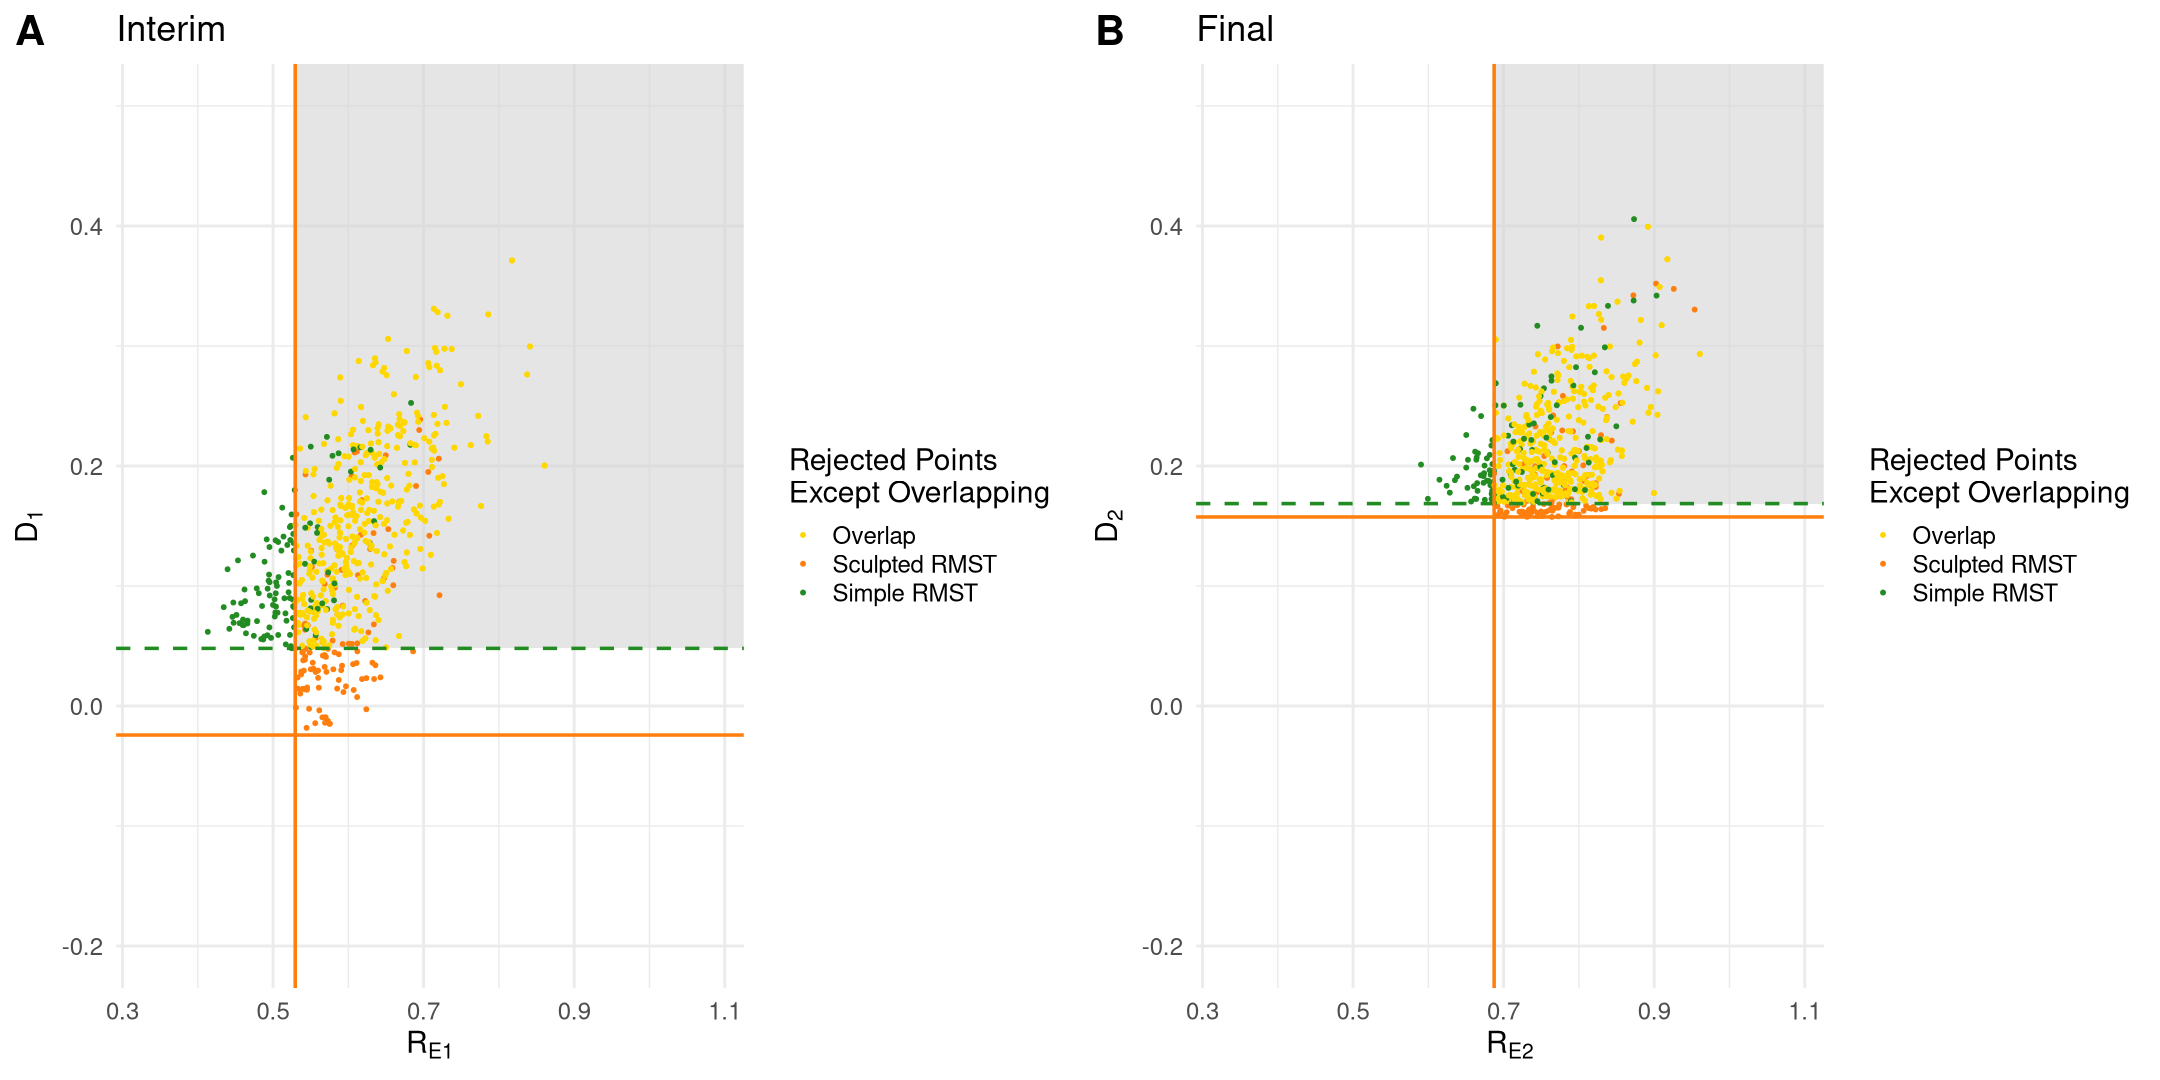

In [89]:
m1 <- as.numeric(best_our1$m1)
q1 <- as.numeric(best_our1$q1)
m2 <- as.numeric(best_our1$m2)
q2 <- as.numeric(best_our1$q2)
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

# data under H0 or H1
rmst_data_plot <- rbind(rmst_h0_int, rmst_h0_fin)
D1 <- rmst_data_plot[2,] - rmst_data_plot[1,]
R1 <- rmst_data_plot[2,]
D2 <- rmst_data_plot[4,] - rmst_data_plot[3,]
R2 <- rmst_data_plot[4,]
# Rejection region
Scu_R <- as.matrix(rmst_data_plot[, which(D1 > m1 & R1 > q1 & D2 > m2 & R2 > q2)])
Sim_R <- as.matrix(rmst_data_plot[, which(D1 > m1_rmst & D2 > m2_rmst)])

# Prepare data for the first scatterplot
data1 <- data.frame(
  x = c(Scu_R[2, ], Sim_R[2, ]),
  y = c(Scu_R[2, ] - Scu_R[1, ], Sim_R[2, ] - Sim_R[1, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data1 <- data1 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

#data1 <- data1[data1$overlap != 'Overlap' , ]
plot1 <- ggplot(data1, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q1, xmax = Inf, ymin = m1_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#FFD700")) +
  labs(title = "Interim", 
      x = expression(R[E1]), 
      y = expression(D[1]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(q1-0.2, q2+0.4) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m1_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) 
  

# Prepare data for the second scatterplot
data2 <- data.frame(
  x = c(Scu_R[4, ], Sim_R[4, ]),
  y = c(Scu_R[4, ] - Scu_R[3, ], Sim_R[4, ] - Sim_R[3, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data2 <- data2 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

#data2 <- data2[data2$overlap != 'Overlap' , ]
plot2 <- ggplot(data2, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q2, xmax = Inf, ymin = m2_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#FFD700")) +
  labs(title = "Final", 
      x = expression(R[E2]), 
      y = expression(D[2]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(q1-0.2, q2+0.4) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m2_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE)


options(repr.plot.width = 18, repr.plot.height = 9)
combined_plot <- plot_grid(plot1, plot2, labels = c("A", "B"), label_size = 25, ncol = 2)
#ggsave("figures/rejection_plot.jpg", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

In [27]:
# green dots outside of shaded region interim
dim(data1[data1$overlap != 'Overlap' & data1$group == 'Simple RMST' & data1$x<q1, ])
# orange dots outside of shaded region interim
dim(data1[data1$overlap != 'Overlap' & data1$group == 'Sculpted RMST' & data1$y<m1_rmst, ])

# green dots out of shaded region final
dim(data2[data2$overlap != 'Overlap' & data2$group == 'Simple RMST' & data2$x < q2, ])
# orange dots out of shaded region final
dim(data2[data2$overlap != 'Overlap' & data2$group == 'Sculpted RMST' & data2$y < m2_rmst, ])


[1] 30  4

[1] 0 4

[1] 190   4

[1] 234   4

### The RMST normality under $H_0$ and $H_1$ at interim

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density2d()`).”


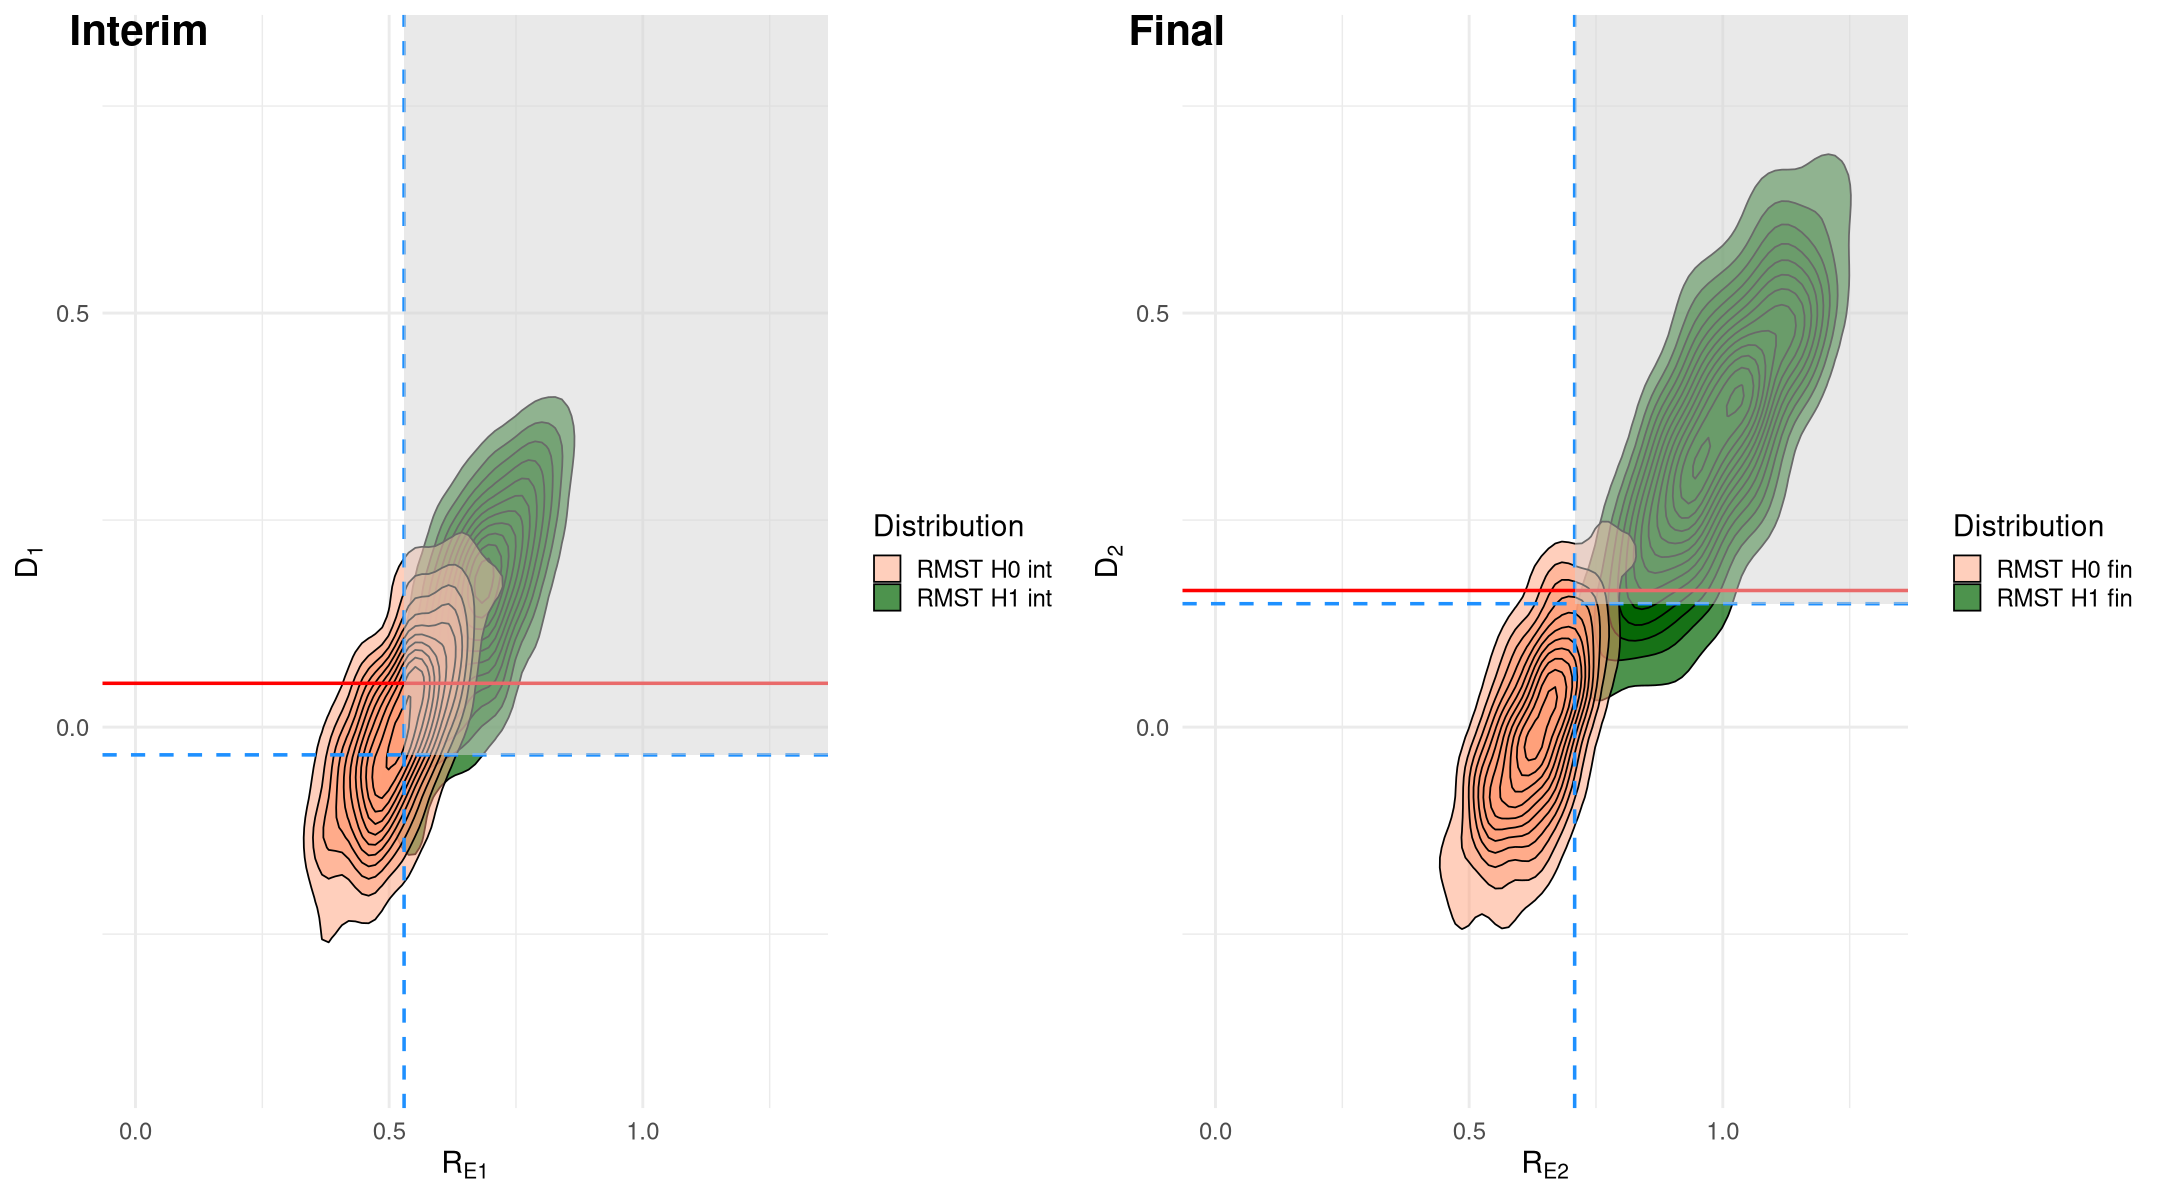

In [81]:
set.seed(2024)
# H0 interm
mu0_i<- mu_cov_h0$mu[c(1,2)]
sigma0_i <- mu_cov_h0$sigma[1:2, 1:2]
#H1 interim 
mu1_i <- mu_cov_h1$mu[c(1,2)]
sigma1_i <- mu_cov_h1$sigma[1:2, 1:2]

# H0 final
mu0_f <- mu_cov_h0$mu[c(3,4)]
sigma0_f <- mu_cov_h0$sigma[3:4, 3:4]
#H1 final 
mu1_f <- mu_cov_h1$mu[c(3,4)]
sigma1_f <- mu_cov_h1$sigma[3:4, 3:4]

data0_i <- mvrnorm(500, mu = mu0_i, Sigma = sigma0_i)
data1_i <- mvrnorm(500, mu = mu1_i, Sigma = sigma1_i)
df0_i <- data.frame(x = data0_i[,1], y = data0_i[,2], group = "RMST H0 int")
df1_i <- data.frame(x = data1_i[,1], y = data1_i[,2], group = "RMST H1 int")

data0_f <- mvrnorm(500, mu = mu0_f, Sigma = sigma0_f)
data1_f <- mvrnorm(500, mu = mu1_f, Sigma = sigma1_f)
df0_f <- data.frame(x = data0_f[,1], y = data0_f[,2], group = "RMST H0 fin")
df1_f <- data.frame(x = data1_f[,1], y = data1_f[,2], group = "RMST H1 fin")

x_i <- as.numeric(best_our1$m1)
y_i <- as.numeric(best_our1$q1)

df1_i <- df1_i[is.finite(df1_i$x) & is.finite(df1_i$y), ]
df0_i <- df0_i[is.finite(df0_i$x) & is.finite(df0_i$y), ]

plot1 <- ggplot() +
     stat_density_2d(data = df1_i, aes(x = y, y = x, fill = "RMST H1 int"), geom = "polygon", alpha = 0.7, color = "black") +
     stat_density_2d(data = df0_i, aes(x = y, y = x, fill = "RMST H0 int"), geom = "polygon", alpha = 0.5, color = "black") +
     scale_fill_manual(values = c("RMST H0 int" = "#FFA07A",  
                               "RMST H1 int" = "#006400")) +  
     theme_minimal(base_size = 18) +
     ylim(-0.4,0.8) +
     xlim(0,1.3) +
     geom_vline(aes(xintercept = y_i), color = "#1E90FF", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
     geom_hline(aes(yintercept = x_i), color = "#1E90FF", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
     geom_hline(aes(yintercept = m1_rmst), color = "#FF0000", linewidth = 1, linetype = "solid", show.legend = FALSE) +
     annotate("rect", xmin = y_i, xmax = Inf, ymin = x_i, ymax = Inf, fill = "lightgrey", alpha = 0.5) +
    
     labs(
       x = expression(R[E1]),
       y = expression(D[1]),
       fill = "Distribution") +
     theme(legend.position = "right")

x_f <- as.numeric(best_our1$m2)
y_f <- as.numeric(best_our1$q2)
df1_f <- df1_f[is.finite(df1_f$x) & is.finite(df1_f$y), ]
df0_f <- df0_f[is.finite(df0_f$x) & is.finite(df0_f$y), ]
plot2 <- ggplot() +
     stat_density_2d(data = df1_f, aes(x = y, y = x, fill = "RMST H1 fin"), 
                    geom = "polygon", alpha = 0.7, color = "black") +
     stat_density_2d(data = df0_f, aes(x = y, y = x, fill = "RMST H0 fin"), 
                    geom = "polygon", alpha = 0.5, color = "black") +
     scale_fill_manual(values = c("RMST H0 fin" = "#FFA07A",  
                               "RMST H1 fin" = "#006400")) +  
     theme_minimal(base_size = 18) +
     ylim(-0.4,0.8) +
     xlim(0,1.3) +
     geom_vline(aes(xintercept = y_f), color = "#1E90FF", linewidth = 1, 
                    linetype = "dashed", show.legend = FALSE) +
     geom_hline(aes(yintercept = x_f), color = "#1E90FF", linewidth = 1, 
                    linetype = "dashed", show.legend = FALSE) +
     geom_hline(aes(yintercept = m2_rmst), color = "#FF0000", linewidth = 1, linetype = "solid", show.legend = FALSE) +               
     annotate("rect", xmin = y_f, xmax = Inf, ymin = x_f, ymax = Inf, fill = "lightgrey", alpha = 0.5) +
     labs(
       x = expression(R[E2]),
       y = expression(D[2]),
       fill = "Distribution") +
     theme(legend.position = "right")

options(repr.plot.width = 18, repr.plot.height = 10)
combined_plot <- plot_grid(plot1, plot2, labels = c("Interim", "Final"), label_size = 25, ncol = 2)
# ggsave("figures/2-d-normal-projection.jpg", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

__________
## Global Robustness
#### Litwin mentioned that when the real distribution parameters vary from the stated ones, the alpha under the same critical values will increase sharply. This method will sacrify globally robustness.
### <span style="color:yellow"> Compare the robustness between LR test and Our method when Hazard Ratio change
#### $\lambda_E| H_1 = 0.9,\ \frac{\lambda_E}{\lambda_C} = 0.67$ Follow Jung 2017 table1

### Mimic the situation that $\lambda_1$ is precise but real $\lambda_0$ deviates from the stated one
#### <span style="color:yellow"> Use the same critical values calculated when $\lambda_0 = 1.2, \lambda_1 = 0.84$
#### $H0: \lambda_E = \lambda_C = \lambda_0$
#### $H1: \lambda_C =  \lambda_0,\ \lambda_E =  \lambda_1$

In [96]:
# Critical value of LR and simple RMST
m1 <- as.numeric(best_our1$m1)
q1 <- as.numeric(best_our1$q1)
m2 <- as.numeric(best_our1$m2)
q2 <- as.numeric(best_our1$q2)
m1_lr <- best_lr$m1
m2_lr <- best_lr$m2
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

# 0.9, 0.9*1.7

# lambda_H0 <- 0.9*1.7
lambda_H1 <- 0.9  #0.84
diff_HR_robust <- foreach(lambda_H0 = seq(1.4, 1.65, by = 0.05), .combine = rbind) %dopar%
{
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

    rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

    z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats

    a_lr <- sum(z_stats_h0_int > m1_lr & z_stats_h0_fin > m2_lr) / sim_size
    power_lr <- sum(z_stats_h1_int > m1_lr & z_stats_h1_fin > m2_lr) / sim_size
    pet0_lr <- sum(z_stats_h0_int <= m1_lr) / sim_size
    pet1_lr <- sum(z_stats_h1_int <= m1_lr) / sim_size

    a_rmst <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1_rmst) &
                    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2_rmst)) / sim_size
    power_rmst <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1_rmst) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2_rmst)) / sim_size
    pet0_rmst <- sum(rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1_rmst) / sim_size
    pet1_rmst <- sum(rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1_rmst) / sim_size

    a_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > q1) &
                (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > q2)) / sim_size
    power_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > q1) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > q2)) / sim_size
    pet0_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1) | (rmst_h0_int[2, ] <= q1)) / sim_size
    pet1_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1) | (rmst_h1_int[2, ] <= q1)) / sim_size
    median_sur <- round(log(2) / lambda_H0 * 12, 2)
    
    return(c( median_sur, a_lr, a_rmst, a_our, power_lr, power_rmst, power_our, 
              pet0_lr, pet0_rmst, pet0_our, pet1_lr, pet1_rmst, pet1_our ))
}

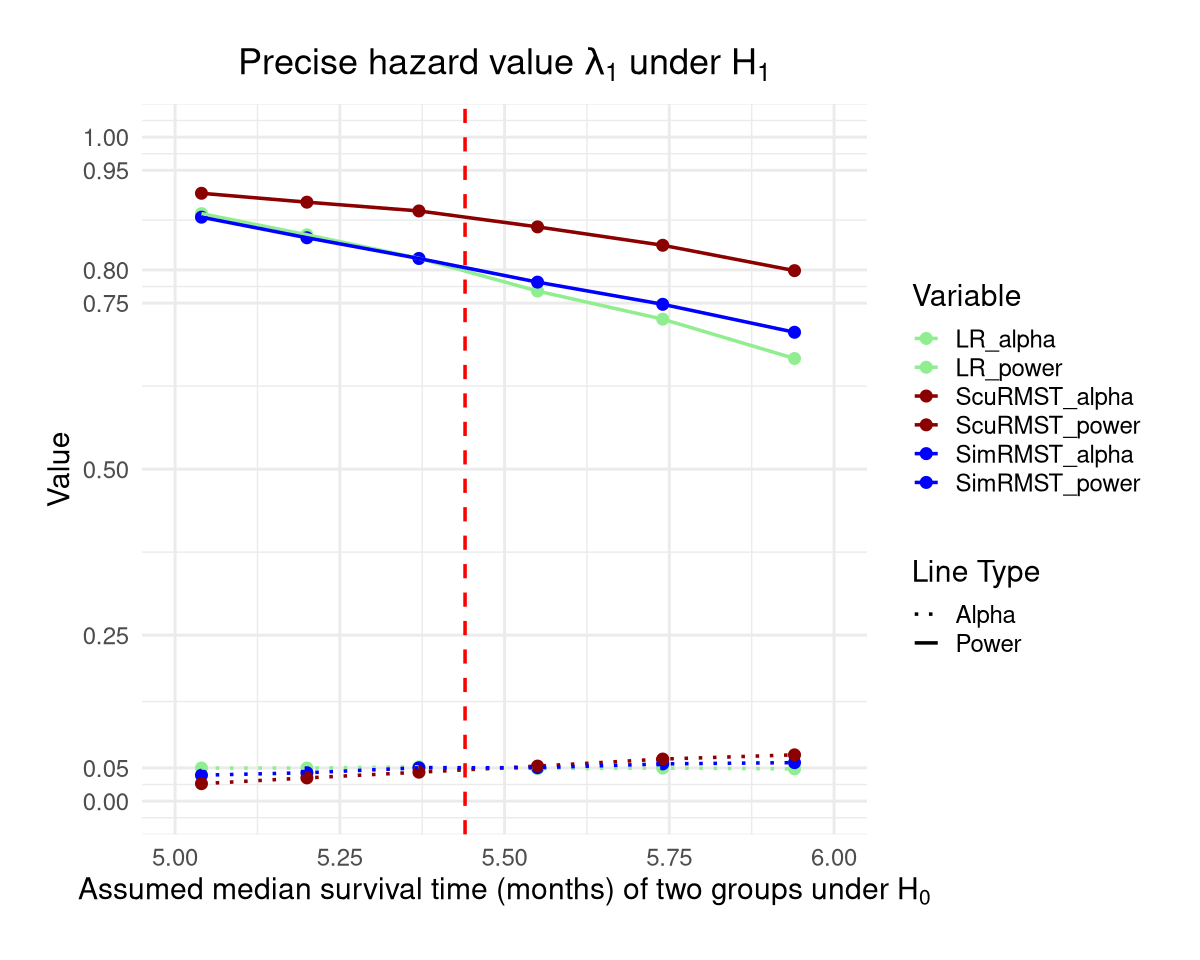

In [97]:
options(repr.plot.width = 10, repr.plot.height = 8)
data <- diff_HR_robust
    color_palette <- c("ScuRMST_power" = "darkred", "ScuRMST_alpha" = "darkred", 
                      "LR_power" = "lightgreen", "LR_alpha" = "lightgreen",
                      "SimRMST_power" = "blue", "SimRMST_alpha" = "blue",
                      "ScuRMST_PET0" = "darkred", "ScuRMST_PET1" = "darkred", 
                      "LR_PET0" = "lightgreen", "LR_PET1" = "lightgreen",
                      "SimRMST_PET0" = "blue", "SimRMST_PET1" = "blue")

    a_power_delta <- data.frame(data[, c(1,2,3,4,5,6,7)])
    colnames(a_power_delta) <- c('lambda_1','LR_alpha','SimRMST_alpha','ScuRMST_alpha',
                          'LR_power', 'SimRMST_power','ScuRMST_power')
    a_power_long <- a_power_delta %>%
        pivot_longer(cols = -!!sym('lambda_1'), names_to = "variable", values_to = "value")%>%
        mutate(linetype_group = ifelse(variable %in% 
            c("LR_alpha", "SimRMST_alpha", "ScuRMST_alpha"), "Alpha", "Power"))
    a_power_long <- a_power_long %>% filter(value != 0)   # 0 means could not find critical values

p_HR2 <- ggplot(a_power_long, aes(x = !!sym('lambda_1'), y = value, 
        color = variable, linetype = linetype_group)) +
    geom_point(size = 3) +
    geom_line(linewidth = 1) +
    geom_vline(xintercept = round(log(2)/1.53*12, 2), color = "red", linetype = "dashed", linewidth = 1) +
    scale_linetype_manual(values = c("Alpha" = "dotted", "Power" = "solid")) +
    labs( linetype = "Line Type", color = "Variable") +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 0.8, 0.95, 1), limits = c(0, 1)) +
    scale_x_continuous(limits = c(5, 6)) +
    scale_color_manual(values = color_palette) +
    labs(x = expression(paste("Assumed median survival time (months) of two groups under ",H[0])), y = "Value", color = "Variable",
      title = expression(paste("Precise hazard value ",lambda[1]," under ", H[1] ))) +
    theme_minimal(base_size = 18) + 
    theme(plot.title = element_text(hjust = 0.5),
          plot.background = element_rect(fill = "white", color = NA),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    guides(linetype = guide_legend(override.aes = list(color = "black")),
        color = guide_legend(override.aes = list(linetype = "solid")))
p_HR2


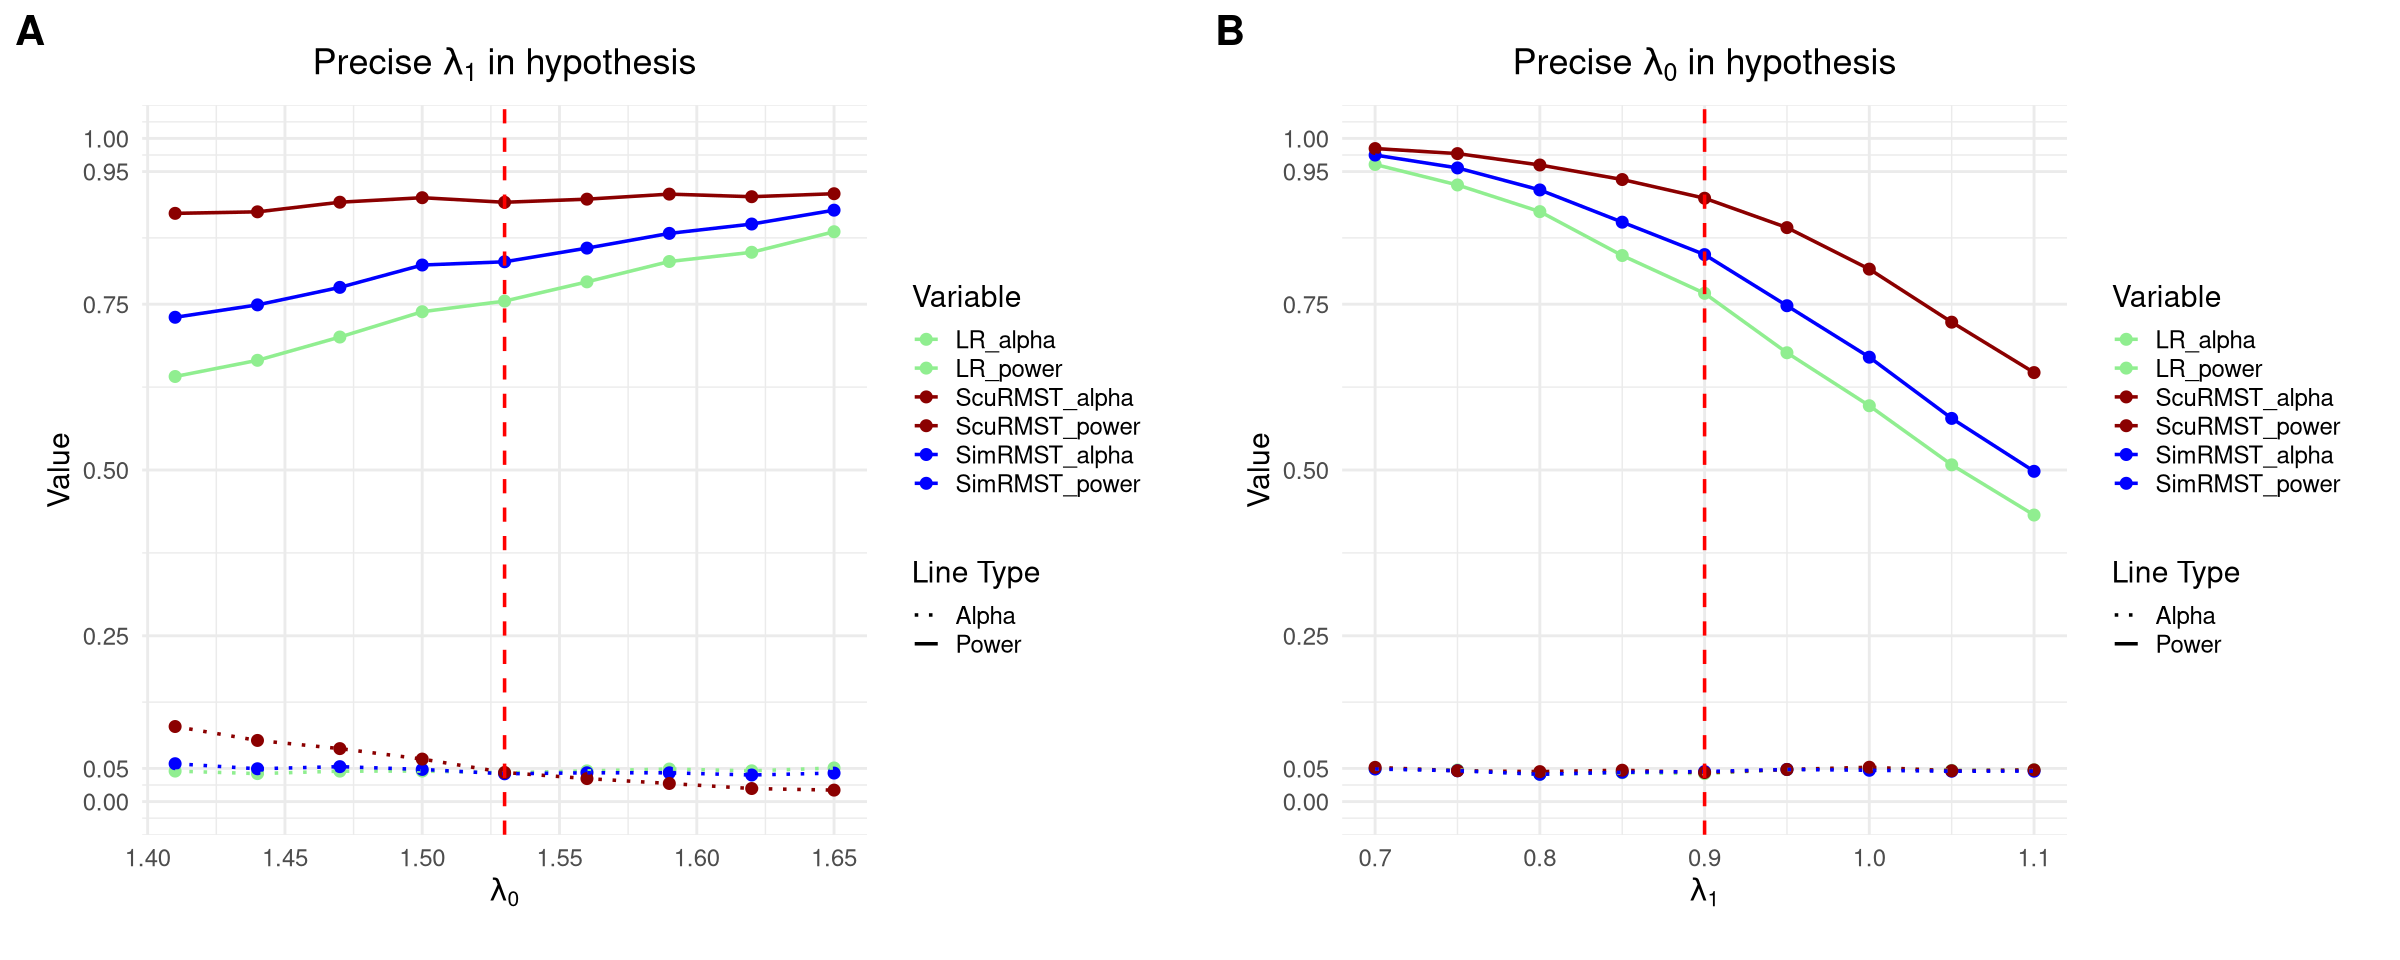

In [14]:
options(repr.plot.width = 20, repr.plot.height = 8)
combined_plot <- plot_grid(p_HR1, p_HR2, labels = c("A", "B"), label_size = 25, ncol = 2)
# ggsave("/home/r27user6/RMST_Code/figures/Robustness.jpg", plot = combined_plot, 
#         width = 18, height = 9, dpi = 300)
combined_plot

### The rejected points when $\lambda_0$ is significantly deviated

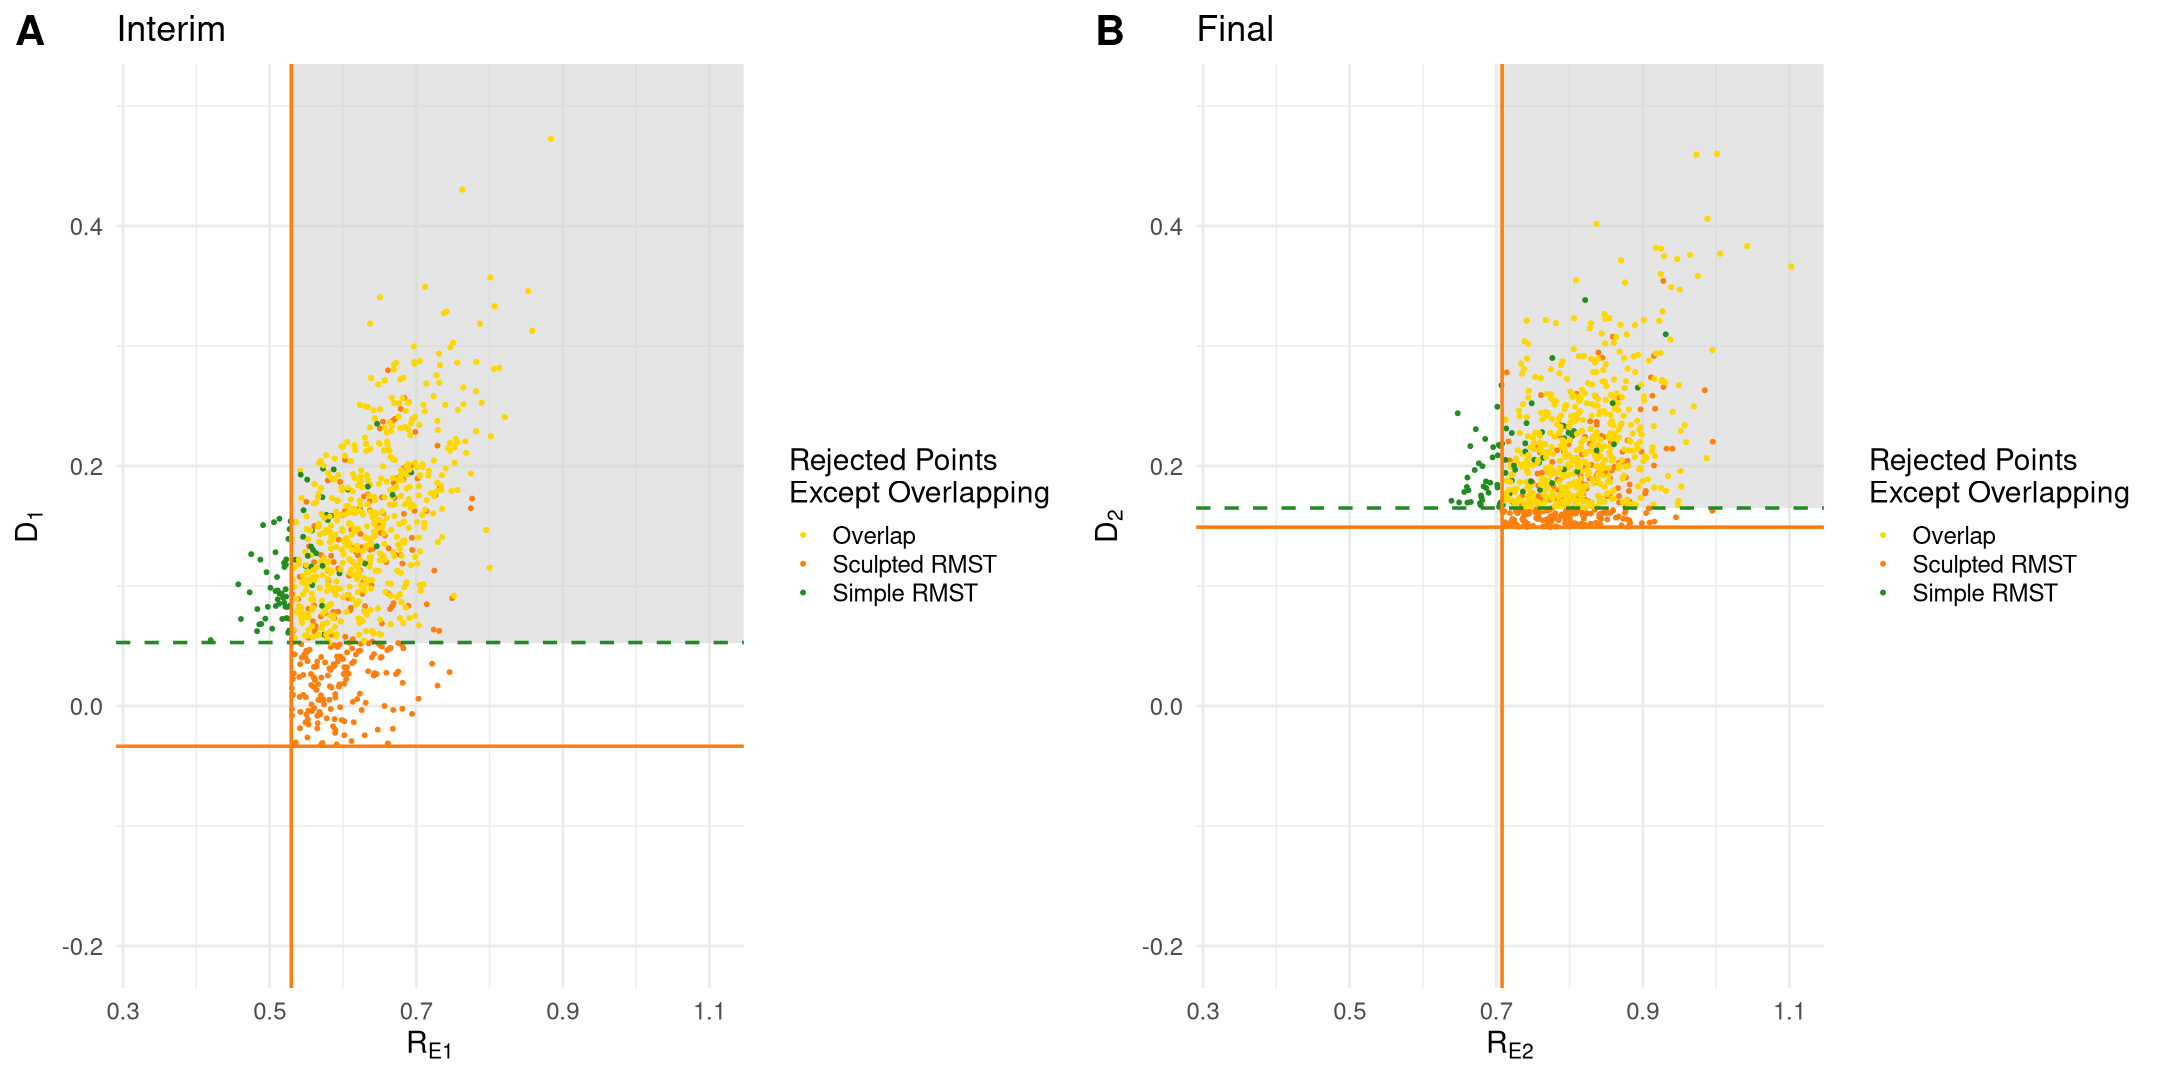

In [79]:
m1 <- as.numeric(best_our1$m1)
q1 <- as.numeric(best_our1$q1)
m2 <- as.numeric(best_our1$m2)
q2 <- as.numeric(best_our1$q2)
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

lambda_H1 <- 0.9 
lambda_H0 <- 1.4
data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

rmst_data_plot <- rbind(rmst_h0_int, rmst_h0_fin)
D1 <- rmst_data_plot[2,] - rmst_data_plot[1,]
R1 <- rmst_data_plot[2,]
D2 <- rmst_data_plot[4,] - rmst_data_plot[3,]
R2 <- rmst_data_plot[4,]
# Rejection region
Scu_R <- as.matrix(rmst_data_plot[, which(D1 > m1 & R1 > q1 & D2 > m2 & R2 > q2)])
Sim_R <- as.matrix(rmst_data_plot[, which(D1 > m1_rmst & D2 > m2_rmst)])

# Prepare data for the first scatterplot
data1 <- data.frame(
  x = c(Scu_R[2, ], Sim_R[2, ]),
  y = c(Scu_R[2, ] - Scu_R[1, ], Sim_R[2, ] - Sim_R[1, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data1 <- data1 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

plot1 <- ggplot(data1, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q1, xmax = Inf, ymin = m1_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#FFD700")) +
  labs(title = "Interim", 
      x = expression(R[E1]), 
      y = expression(D[1]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(q1-0.2, q2+0.4) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m1_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) 
  

# Prepare data for the second scatterplot
data2 <- data.frame(
  x = c(Scu_R[4, ], Sim_R[4, ]),
  y = c(Scu_R[4, ] - Scu_R[3, ], Sim_R[4, ] - Sim_R[3, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data2 <- data2 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

plot2 <- ggplot(data2, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q2, xmax = Inf, ymin = m2_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#FFD700")) +
  labs(title = "Final", 
      x = expression(R[E2]), 
      y = expression(D[2]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(q1-0.2, q2+0.4) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m2_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE)


options(repr.plot.width = 18, repr.plot.height = 9)
combined_plot <- plot_grid(plot1, plot2, labels = c("A", "B"), label_size = 25, ncol = 2)
combined_plot


In [80]:
sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > q1) &
                (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > q2)) / sim_size
sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > q1) &
                (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > q2)) / sim_size

[1] 0.8188

[1] 0.0774

-------